## Pooled Variance Notes

Hutter et al. [], describe a random forest surrogate model.  The paper described 
an algorithm for combining decision tree predictions (leaf means and variance estimates) to
produce tree predictions together with confidence intervals.  We present their mathematics 
below and have used this in the MLOS HomogeneousRandomForestRegressionModel.  
On reading Hutter et al.'s prescription for summarizing leaf predictions, it seemed some 
classical statistics (pooled variance, Welch-Satterthwaite degrees of freedom)
based summarization methods might be more accurate while also being more robust.  
This notebook explores/explains both strategies and used simulated data from 
normal, lognormal, and chi-square distributed observations.

### Hutter et al.'s summarization

The mean of leaf means is recommended for the random forest's predicted value.  
Specifically $\mu = \frac{1}{B}\sum_{b=1}^{B}\mu_b$ where $B$ is the number of participating
decision trees in a random forest prediction and $\mu_b$ is empirical mean of the training data associated 
with the $b^{th}$ tree.

The forest's variance estimate uses the law of total variance and estimates 
$\sigma^2 = \left( \frac{1}{B} \sum_{b=1}^B\sigma_b^2 + \mu_b^2 \right) - \mu^2$ 
where $\sigma_b^2$ is the empirical variance from the $b^{th}$ leaf and $\mu$ as computed above.

We think one can better pool the leave's summary data (details below) because:
1. The mean of means isn't always the mean of all the observed values partitioned to the prediction leaves from the forest.
1. The variance estimate assumes the probability of an observation being assigned to each leaf is uniform ($\frac{1}{B}$).
    1. This then leads one to conclude expected variance is the mean of the leaf variances.
    
The assumption supporting the mean of means is invalid when each subpopulation fails to contain the same number of observations.
The variance assumption violates classicial statistical methods for pooled variances from subsampled populations, and these 
methods do not rely on uniform leaf population counts or equal leaf variances.


### Proposed alternative summarization
This notebook proposes replacing Hutter et al.'s "mean of means" strategy with an exact computation of the mean of the 
all leaf observations supporting a prediction.  
Specifically, $\mu = \left( \sum_{b=1}^B n_b \mu_b \right) / \left( \sum_{b=1}^{B} n_b \right)$ 
where $n_b$ is the sample count for the $b^{th}$ leaf, 
and the pooled variance estimate is $\sigma^2 = \sum_{b=1}^B \frac{\sigma_b^2}{n_b}$.
This pooled variance expression is common in statistical hypothesis testing of sample mean differences
where the assumption of equal population sample variances can not be ensured (see Welch t-tests for example).
Moreover, the Welch-Satterthwaite degrees of freedom adjustment has proven to be robust estimate of pooled variance
degrees of freedom.


### Summarization Comparisons 

In the comparisons at the end of this notebook, the estimates based on Hutter et al.'s recommendation will be labelled as 
`Hutter math`, while those suggested by classical Welch-Satterthwaite will be labelled as `WS math`.


### References
1. Hutter et al. Algorithm Runtime Prediction: Methods & Evaluation, 2013, Section 4.3.2 [https://arxiv.org/pdf/1211.0906.pdf]
    1. Original paper on random forest surrogate models:
1. Welch t-test:
    1. https://www.itl.nist.gov/div898/software/dataplot/refman2/auxillar/welchsat.htm - description #2
    1. https://en.wikipedia.org/wiki/Welch%27s_t-test
1. Welch-Satterthwaite degrees of freedom: https://en.wikipedia.org/wiki/Welch%E2%80%93Satterthwaite_equation
1. Pooled variance: https://en.wikipedia.org/wiki/Pooled_variance


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important; }</style>"))

import numpy as np
import pandas as pd
from scipy.stats import t
import matplotlib.pyplot as plt

def simulate_data_seen_at_tree_leaf(population_mean, population_variance, num_trees, average_obs_per_leaf, distribution_name):
    num_obs_in_tree_leaf = np.random.poisson(average_obs_per_leaf, size=(num_trees,1))
    total_num_obs = np.sum(num_obs_in_tree_leaf)
    if distribution_name.upper() == 'normal'.upper():
        candidate_obs = np.random.normal(population_mean, population_variance, size=total_num_obs)
    elif distribution_name.upper() == 'lognormal'.upper():
        candidate_obs = np.random.lognormal(population_mean, population_variance, size=total_num_obs)
    elif distribution_name.upper() == 'chisquared'.upper():
        candidate_obs = np.random.chisquare(population_mean, size=total_num_obs)
    else:
        print(f'Distribution name "{distribution_name}" not yet implemented')
    
    # sample from candidate values to assign to leaves : done so that some leaves may contain the same obs values
    tree_leaf_obs = []
    all_obs_values = []        
    for sample_size in num_obs_in_tree_leaf:
        tree_leaf_y_values = np.random.choice(candidate_obs, size=sample_size, replace=False) # no obs is duplicated in a leaf
        tree_leaf_obs.append(pd.DataFrame({'y': tree_leaf_y_values}))
        all_obs_values.extend(tree_leaf_y_values)

    sample_obs_for_summary = candidate_obs
    num_obs = len(sample_obs_for_summary)
    overall_mean = np.mean(sample_obs_for_summary)
    overall_sample_var = np.var(sample_obs_for_summary, ddof=1)
    overall_mean_var = overall_sample_var / num_obs
    
    return tree_leaf_obs, overall_mean, overall_sample_var, overall_mean_var, num_obs

def compute_overall_stats_from_leaves(tree_leaf_obs):
    all_obs_values = []
    for leaf_obs in tree_leaf_obs:
        all_obs_values.extend(leaf_obs['y'].values)
    # compute stats across all observations seen in the leaves
    num_obs_across_all_leaves = len(all_obs_values)
    overall_mean = np.mean(all_obs_values)
    overall_sample_var = np.var(all_obs_values, ddof=1)
    overall_mean_var = overall_sample_var / num_obs_across_all_leaves
    #print(f'\noverall sample mean: {overall_mean}, sample var: {overall_sample_var}, mean var: {overall_mean_var}\n')

    return overall_mean, overall_sample_var, overall_mean_var, num_obs_across_all_leaves

def compute_cdf(x_df,
                x_field_name=None,
                by_field_name=None):
    cdf_by_prelim = {
        'by_var': [],
        'x': [],
        'cdf': []
    }
    if by_field_name is None:
        by_field_name = '__null_by_var'
        x_df[by_field_name] = 1
    by_var_levels = x_df[by_field_name].unique()
    
    for bvl in by_var_levels:
        slice_df = x_df.loc[x_df[by_field_name] == bvl, x_field_name].to_frame(x_field_name)
        n = slice_df.size
        slice_df.sort_values(by=x_field_name, ascending=True, inplace=True)
        
        cdf_by_prelim['x'].extend(slice_df[x_field_name])
        cdf_by_prelim['by_var'].extend([bvl]*n)
        cdf = np.arange(1, n+1) / n
        cdf_by_prelim['cdf'].extend(cdf.tolist())
    cdf = pd.DataFrame(cdf_by_prelim)
    
    return cdf

def plot_cdf_overlays(cdf_df, 
                      title,
                      xlabel,
                      show_hutter_plots=True):
    colors = ['r', 'b', 'g']
    symbols = ['o', 'x']
    i = 0
    j = 0
    fig = plt.figure(figsize=(12,7))
    my_label_root = 'Welch math, '
    my_label = my_label_root + f'num_trees={num_trees_simulated[i]}'
    my_slice = cdf_df.loc[(cdf_df['summary_stats_method']=='welch') &
                          (cdf_df['num_trees']== ' num_trees='+str(num_trees_simulated[i])), :]
    plt.plot(my_slice['x'], my_slice['cdf'], '-'+colors[i]+symbols[j], label=my_label)
    i = (i + 1) % 3
    
    
    my_label = my_label_root + f'num_trees={num_trees_simulated[i]}'
    my_slice = cdf_df.loc[(cdf_df['summary_stats_method']=='welch') &
                          (cdf_df['num_trees']== ' num_trees='+str(num_trees_simulated[i])), :]
    plt.plot(my_slice['x'], my_slice['cdf'], '-'+colors[i]+symbols[j], label=my_label)
    i = (i + 1) % 3

    my_label = my_label_root + f'num_trees={num_trees_simulated[i]}'
    my_slice = cdf_df.loc[(cdf_df['summary_stats_method']=='welch') &
                          (cdf_df['num_trees']== ' num_trees='+str(num_trees_simulated[i])), :]
    plt.plot(my_slice['x'], my_slice['cdf'], '-'+colors[i]+symbols[j], label=my_label)
    i = (i + 1) % 3
    
    if show_hutter_plots:
        j = (j + 1) % 2
        my_label_root = 'Hutter math, '
        my_label = my_label_root + f'num_trees={num_trees_simulated[i]}'
        my_slice = cdf_df.loc[(cdf_df['summary_stats_method']=='hutter') &
                              (cdf_df['num_trees']== ' num_trees='+str(num_trees_simulated[i])), :]
        plt.plot(my_slice['x'], my_slice['cdf'], '-'+colors[i]+symbols[j], label=my_label)
        i = (i + 1) % 3

        my_label = my_label_root + f'num_trees={num_trees_simulated[i]}'
        my_slice = cdf_df.loc[(cdf_df['summary_stats_method']=='hutter') &
                              (cdf_df['num_trees']== ' num_trees='+str(num_trees_simulated[i])), :]
        plt.plot(my_slice['x'], my_slice['cdf'], '-'+colors[i]+symbols[j], label=my_label)
        i = (i + 1) % 3

        my_label = my_label_root + f'num_trees={num_trees_simulated[i]}'
        my_slice = cdf_df.loc[(cdf_df['summary_stats_method']=='hutter') &
                              (cdf_df['num_trees']== ' num_trees='+str(num_trees_simulated[i])), :]
        plt.plot(my_slice['x'], my_slice['cdf'], '-'+colors[i]+symbols[j], label=my_label)
        i = (i + 1) % 3
    
    plt.xlabel(xlabel)
    plt.ylabel('Cumulative Distribution')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


Bad key "text.kerning_factor" on line 4 in
C:\Users\edthaye\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


The next helper function replicates code from the `.predict()` methods in `HomogeneousRandomForestRegressionModel` and `DecisionTreeRegressionModel` to compute Hutter's estimates for both sample mean, sample variance, and mean variance.  In addition, the recommended alternative forest summarizations are coded against the pandas dataframe `all_predictions_df` as we expect would add these to the MLOS random forest surrogate model.

In [2]:
def compute_homogeneuous_random_forest_predictions(tree_leaf_obs):

    # compute the predictions dataframes returned for each tree
    # producing a prediction dataframe (with a single row) for each tree leaf
    # mimics code from DecisionTreeRegressionModel to build prediction dataframes
    prediction_dataframes_per_tree = []
    for i, leaf_obs_df in enumerate(tree_leaf_obs):
        leaf_obs = leaf_obs_df['y'].values
        count_per_leaf = len(leaf_obs)
        leaf_mean = np.mean(leaf_obs)
        leaf_sample_variance = np.var(leaf_obs, ddof=1)
        leaf_mean_variance = leaf_sample_variance / count_per_leaf
        #print(f'Tree {i} mean={leaf_mean}, mean variance={leaf_mean_variance} [N={count_per_leaf}]')
        prediction_dict = {
                'leaf_node_index': [i],
                 predicted_value_col: [leaf_mean],
                 predicted_value_var_col: [leaf_mean_variance],
                 sample_var_col : [leaf_sample_variance],
                 sample_size_col : [count_per_leaf],
                 dof_col : [count_per_leaf - 1],
                 is_valid_input_col: [True]
            }
        tree_prediction = pd.DataFrame(prediction_dict)
        prediction_dataframes_per_tree.append(tree_prediction)

    # code from HomogeneousRandomForestRegressionModel.predict()
    num_prediction_dataframes = len(prediction_dataframes_per_tree)
    # We will be concatenating all these prediction dataframes together, but to to avoid duplicate columns, we first rename them.
    #
    old_names = [predicted_value_col, predicted_value_var_col, sample_var_col, sample_size_col, dof_col]
    predicted_value_col_names_per_tree = [f"{predicted_value_col}_{i}" for i in range(num_prediction_dataframes)]
    mean_var_col_names_per_tree = [f"{predicted_value_var_col}_{i}" for i in range(num_prediction_dataframes)]
    sample_var_col_names_per_tree = [f"{sample_var_col}_{i}" for i in range(num_prediction_dataframes)]
    sample_size_col_names_per_tree = [f"{sample_size_col}_{i}" for i in range(num_prediction_dataframes)]    

    for i in range(num_prediction_dataframes):
        new_names = [f"{old_name}_{i}" for old_name in old_names]
        old_names_to_new_names_mapping = {old_name: new_name for old_name, new_name in zip(old_names, new_names)}
        prediction_dataframes_per_tree[i].drop(columns=[is_valid_input_col], inplace=True)
        # We can safely overwrite them in place since we are their sole owner by now.
        prediction_dataframes_per_tree[i].rename(columns=old_names_to_new_names_mapping, inplace=True)

    # This creates a 'wide' dataframe with unique column names.
    #
    all_predictions_df = pd.concat(prediction_dataframes_per_tree, axis=1)
    all_predictions_df[predicted_value_col] = all_predictions_df[predicted_value_col_names_per_tree].apply('mean', axis=1)

    # To compute the pooled variance we will use the second to last form of the equation from the paper:
    #   paper: https://arxiv.org/pdf/1211.0906.pdf
    #   section: section: 4.3.2 for details
    all_predictions_df[predicted_value_var_col] = all_predictions_df[mean_var_col_names_per_tree].mean(axis=1) \
                                         + (all_predictions_df[predicted_value_col_names_per_tree] ** 2).mean(axis=1) \
                                         - all_predictions_df[predicted_value_col] ** 2 + 0.0000001 # A little numerical instability correction
    all_predictions_df[sample_var_col] = all_predictions_df[sample_var_col_names_per_tree].mean(axis=1) \
                                         + (all_predictions_df[predicted_value_col_names_per_tree] ** 2).mean(axis=1) \
                                         - all_predictions_df[predicted_value_col] ** 2 + 0.0000001 # A little numerical instability correction
    all_predictions_df[sample_size_col] = all_predictions_df[predicted_value_col_names_per_tree].count(axis=1)
    all_predictions_df[dof_col] = all_predictions_df[sample_size_col_names_per_tree].sum(axis=1) - all_predictions_df[sample_size_col]
    # END CODE TAKEN FROM HRF.predict()

    # new prediction columns : to be added to HRF.predict()
    predicted_value_variance_col_names_per_tree = [f"{predicted_value_var_col}_{i}" for i in range(num_prediction_dataframes)]
    predicted_value_variance_dof_col_names_per_tree = [f"{dof_col}_{i}" for i in range(num_prediction_dataframes)]
    # need to know how many trees returned a prediction for each input row
    #  using sample size columns from each tree as a surrogate for presence/absence of a prediction from the total possible number of trees
    not_na = np.logical_not(all_predictions_df[sample_size_col_names_per_tree].isna())
    num_prediction_trees = not_na.sum(axis=1)

    # need to test how these rows operate in the presence of NaNs (from trees failing to make a prediction)
    predicted_values = all_predictions_df[predicted_value_col_names_per_tree].values
    predicted_values_var = all_predictions_df[predicted_value_variance_col_names_per_tree].values
    predicted_values_dof = all_predictions_df[predicted_value_variance_dof_col_names_per_tree].values
    sample_sizes = all_predictions_df[sample_size_col_names_per_tree].values
    sample_var = all_predictions_df[sample_var_col_names_per_tree].values
    
    all_predictions_df[new_predicted_mean_value_col] = np.nansum(sample_sizes * predicted_values, axis=1) / np.nansum(sample_sizes, axis=1)
    all_predictions_df[new_predicted_mean_value_var_col] = np.nansum(predicted_values_dof * predicted_values_var, axis=1) / np.nansum(predicted_values_dof, axis=1) / num_prediction_trees
    all_predictions_df[new_predicted_mean_var_dof_col] = num_prediction_trees - 1
    
    all_predictions_df[new_sample_var_col] = np.nansum(predicted_values_dof * sample_var, axis=1) / np.nansum(predicted_values_dof, axis=1)
    all_predictions_df[new_sample_var_dof_col] = np.nansum(sample_var / sample_sizes, axis=1)**2 \
            / np.nansum(((sample_var / sample_sizes)**2) / predicted_values_dof, axis=1)
    
    return all_predictions_df

### Measure relative change from known sample measures

The next cell compares the Hutter recommended statistics for predicted values and variances to those recommended from classical statistics by varying the following "parameters":
1. Number of trees used in the approximation
1. Number of points sampled and their overlap
1. Three population simulation distributions (normal, lognormal, chi-squared).

Differences are assessed using relative change from the known/overall sample populations statistics (https://en.wikipedia.org/wiki/Relative_change_and_difference) with `num_replicates` replicates summarized using cummulative distribution functions (CDFs).


In [3]:
# compute summaries produced by decision trees given the mock "leaf" data
# shortcutted (copy-n-pasted) the column names from the Prediction.LegalColumnNames
is_valid_input_col = 'is_valid_input' # Prediction.LegalColumnNames.IS_VALID_INPUT.value
predicted_value_col = 'predicted_value' # Prediction.LegalColumnNames.PREDICTED_VALUE.value
predicted_value_var_col = 'predicted_value_variance' # Prediction.LegalColumnNames.PREDICTED_VALUE_VARIANCE.value
sample_var_col = 'sample_variance' # Prediction.LegalColumnNames.SAMPLE_VARIANCE.value
sample_size_col = 'sample_size' # Prediction.LegalColumnNames.SAMPLE_SIZE.value
dof_col = 'predicted_value_degrees_of_freedom' # Prediction.LegalColumnNames.PREDICTED_VALUE_DEGREES_OF_FREEDOM.value

# add new predicted value, sample variance, sample degrees of freedom, predicted value variance
#  "Prediction.LegalColumnNames" to be added to HRF predict() method
new_predicted_mean_value_col = 'sample_weighted_predicted_value'
new_predicted_mean_value_var_col = 'sample_weighted_predicted_value_variance'
new_predicted_mean_var_dof_col = 'sample_weighted_predicted_value_variance_degrees_of_freedom'
new_sample_var_col = 'pooled_sample_variance'
new_sample_var_dof_col = 'pooled_sample_variance_degrees_of_freedom'
    
num_replicates = 30
summary_data = {k : [] for k in ['replicate',
                                 'overall_mean',
                                 'overall_sample_var',
                                 'overall_sample_95P_CI_radius',
                                 'overall_mean_var',
                                 'overall_mean_95P_CI_radius',
                                 'experiment_defn',
                                 'hutter_predicted_value',
                                 'welch_predicted_value',
                                 'hutter_predicted_value_var',
                                 'hutter_predicted_value_95P_CI_radius',
                                 'welch_predicted_value_var',
                                 'welch_prediction_dof',
                                 'welch_predicted_value_95P_CI_radius',
                                 'hutter_sample_var',
                                 'welch_sample_var',
                                 'hutter_dof',
                                 'welch_sample_dof',
                                 'welch_sample_95P_CI_radius'
                                ]}
# overall population distribution
alpha = 0.05
global_mean = 5.0
global_var = 2.0
ave_num_obs_per_leaf = 12
num_trees_simulated = [5, 10, 25]
for num_trees in num_trees_simulated:
    for distribution_name in ['normal', 'lognormal', 'chisquared']:
        for i in range(num_replicates):
            (tree_leaf_obs,
             overall_mean, 
             overall_sample_var,
             overall_mean_var, 
             num_obs_across_all_leaves) = simulate_data_seen_at_tree_leaf(global_mean, global_var, num_trees, ave_num_obs_per_leaf, distribution_name)
            
            

            # aggregate summary info
            summary_data['replicate'].append(i)
            summary_data['experiment_defn'].append(f'dist={distribution_name}, num_trees={num_trees}')

            summary_data['overall_mean'].append(overall_mean) 
            summary_data['overall_sample_var'].append(overall_sample_var)
            summary_data['overall_mean_var'].append(overall_mean_var)
            overall_mean_var_dof = num_trees-1
            t_values = t.ppf(1 - alpha / 2.0, overall_mean_var_dof)
            confidence_interval_radii = t_values * np.sqrt(overall_mean_var)
            summary_data['overall_mean_95P_CI_radius'].append(confidence_interval_radii)
            
            overall_sample_var_dof = num_obs_across_all_leaves - num_trees
            t_values = t.ppf(1 - alpha / 2.0, overall_sample_var_dof)
            confidence_interval_radii = t_values * np.sqrt(overall_sample_var)
            summary_data['overall_sample_95P_CI_radius'].append(confidence_interval_radii)
            
            # compute Hutter and Welch-Satterthwaite summary statistics
            all_predictions_df = compute_homogeneuous_random_forest_predictions(tree_leaf_obs)

            # add Hutter measures to summary data
            summary_data['hutter_predicted_value'].append(all_predictions_df[predicted_value_col].values[0])
            summary_data['hutter_predicted_value_var'].append(all_predictions_df[predicted_value_var_col].values[0])
            summary_data['hutter_dof'].append(all_predictions_df[dof_col].values[0])
            t_values = t.ppf(1 - alpha / 2.0, all_predictions_df[dof_col].values[0])
            confidence_interval_radii = t_values * np.sqrt(all_predictions_df[predicted_value_var_col].values[0])
            summary_data['hutter_predicted_value_95P_CI_radius'].append(confidence_interval_radii)
            summary_data['hutter_sample_var'].append(all_predictions_df[sample_var_col].values[0])
            
            # add Welch-Satterthwaite based measures to summary data
            summary_data['welch_predicted_value'].append(all_predictions_df[new_predicted_mean_value_col].values[0]) 
            summary_data['welch_predicted_value_var'].append(all_predictions_df[new_predicted_mean_value_var_col].values[0])
            summary_data['welch_prediction_dof'].append(all_predictions_df[new_predicted_mean_var_dof_col].values[0])
            t_values = t.ppf(1 - alpha / 2.0, all_predictions_df[new_predicted_mean_var_dof_col].values[0])
            confidence_interval_radii = t_values * np.sqrt(all_predictions_df[new_predicted_mean_value_var_col].values[0])
            summary_data['welch_predicted_value_95P_CI_radius'].append(confidence_interval_radii)
            
            summary_data['welch_sample_var'].append(all_predictions_df[new_sample_var_col].values[0])
            summary_data['welch_sample_dof'].append(all_predictions_df[new_sample_var_dof_col].values[0])
            t_values = t.ppf(1 - alpha / 2.0, all_predictions_df[new_sample_var_dof_col].values[0])
            confidence_interval_radii = t_values * np.sqrt(all_predictions_df[new_sample_var_col].values[0])
            summary_data['welch_sample_95P_CI_radius'].append(confidence_interval_radii)
            
summary_df = pd.DataFrame(summary_data)

# add relative change columns
for col_name_prefix in ['hutter', 'welch']:
    summary_df[f'{col_name_prefix}_mean_relative_change'] = 100 * (summary_df[f'{col_name_prefix}_predicted_value'] - summary_df['overall_mean']) / summary_df['overall_mean']
    summary_df[f'{col_name_prefix}_sample_var_relative_change'] = 100 * (summary_df[f'{col_name_prefix}_sample_var'] - summary_df['overall_sample_var'] ) / summary_df['overall_sample_var']
    summary_df[f'{col_name_prefix}_predicted_var_relative_change'] = 100 * (summary_df[f'{col_name_prefix}_predicted_value_var'] - summary_df['overall_mean_var'] ) / summary_df['overall_mean_var']
    summary_df[f'{col_name_prefix}_predicted_value_95P_CI_radius_relative_change'] = 100 * (summary_df[f'{col_name_prefix}_predicted_value_95P_CI_radius'] - summary_df['overall_mean_95P_CI_radius'] ) / summary_df['overall_mean_95P_CI_radius']

# save for offline exploration
summary_df.to_csv('pooled_var_test.tsv', sep='\t', index=False)   

In [4]:
# compute and display cdfs of relative_changes
all_cdfs = []

for measure_name in ['mean_relative_change', 
                     'sample_var_relative_change', 
                     'predicted_var_relative_change', 
                     'predicted_value_95P_CI_radius_relative_change']:
    for experiment_defn in summary_df['experiment_defn'].unique():
        summary_slice_df = summary_df.loc[summary_df['experiment_defn']==experiment_defn, :].copy()
        hrf_mean_relative_change_cdf = compute_cdf(summary_slice_df, 'hutter_' + measure_name)
        pooled_mean_relative_change_cdf = compute_cdf(summary_slice_df, 'welch_' + measure_name)
               
        # retain the cdfs for offline exploration
        hrf_mean_relative_change_cdf['summary_stats_method'] = 'hutter'
        hrf_mean_relative_change_cdf['experiment_defn'] = experiment_defn
        hrf_mean_relative_change_cdf['measure_name'] = measure_name
        all_cdfs.append(hrf_mean_relative_change_cdf)
        
        pooled_mean_relative_change_cdf['summary_stats_method'] = 'welch'
        pooled_mean_relative_change_cdf['experiment_defn'] = experiment_defn
        pooled_mean_relative_change_cdf['measure_name'] = measure_name
        all_cdfs.append(pooled_mean_relative_change_cdf)
        
all_cdfs_df = pd.concat(all_cdfs)
all_cdfs_df['distribution'] = ''
all_cdfs_df['num_trees'] = ''
all_cdfs_df[['distribution', 'num_trees']] = all_cdfs_df['experiment_defn'].str.split(',', expand=True)

all_cdfs_df.to_csv('pooled_var_tests.CDFs.tsv', sep='\t', index=False)

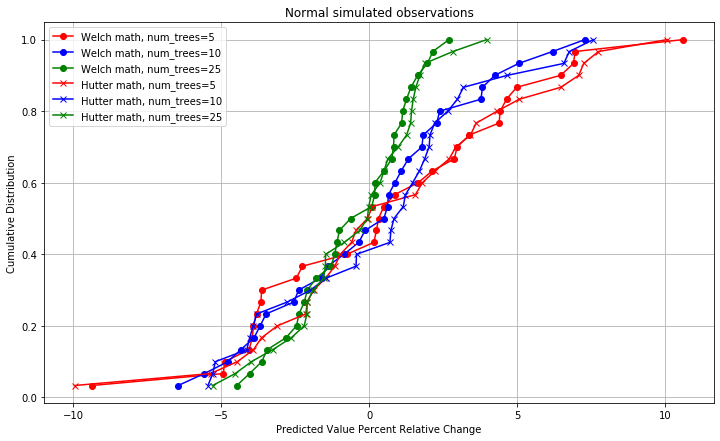

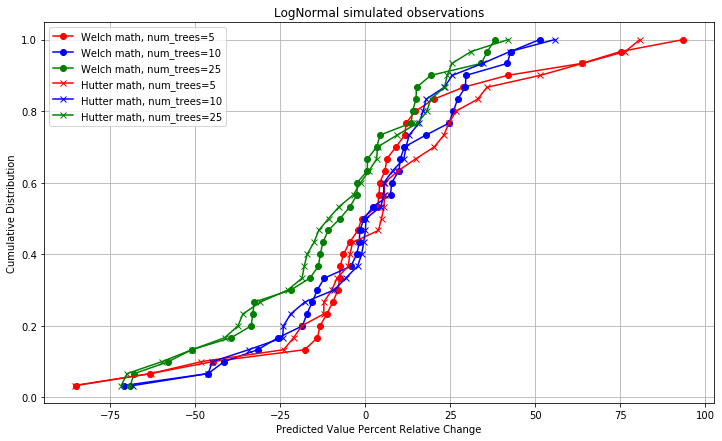

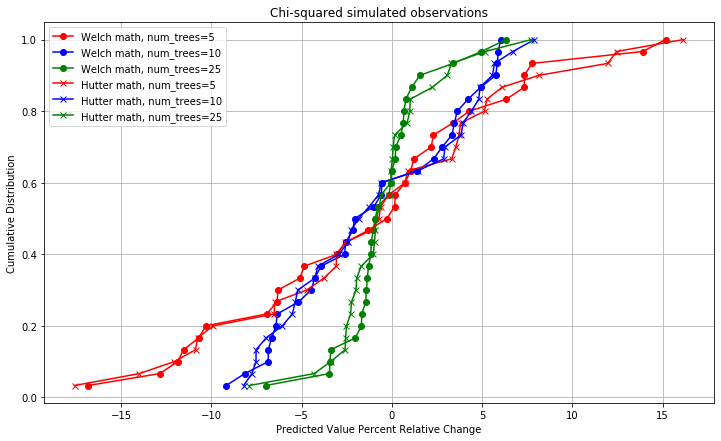

In [5]:
## plot combined CDF figs

# predicted value
xlabel = 'Predicted Value Percent Relative Change'
measurement_cdfs = all_cdfs_df.loc[all_cdfs_df['measure_name'] == 'mean_relative_change', :]
normal_cdf_sample_var = measurement_cdfs.loc[measurement_cdfs['distribution'] == 'dist=normal', :]
plot_cdf_overlays(normal_cdf_sample_var, 'Normal simulated observations', xlabel)

lognormal_cdf_sample_var = measurement_cdfs.loc[measurement_cdfs['distribution'] == 'dist=lognormal', :]
plot_cdf_overlays(lognormal_cdf_sample_var, 'LogNormal simulated observations', xlabel)

chi_sq_cdf_sample_var = measurement_cdfs.loc[measurement_cdfs['distribution'] == 'dist=chisquared', :]
plot_cdf_overlays(chi_sq_cdf_sample_var, 'Chi-squared simulated observations', xlabel)


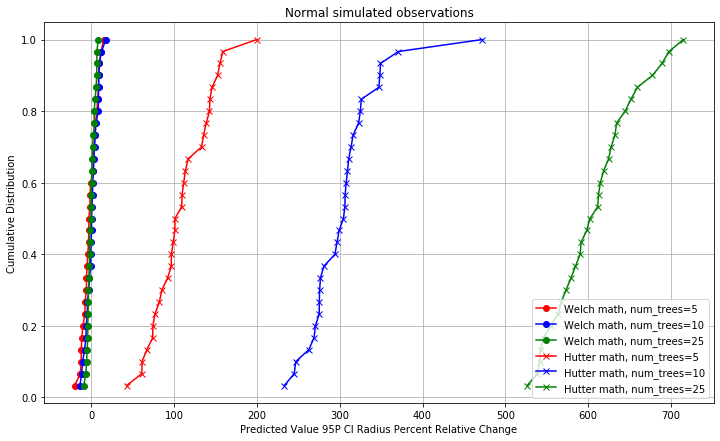

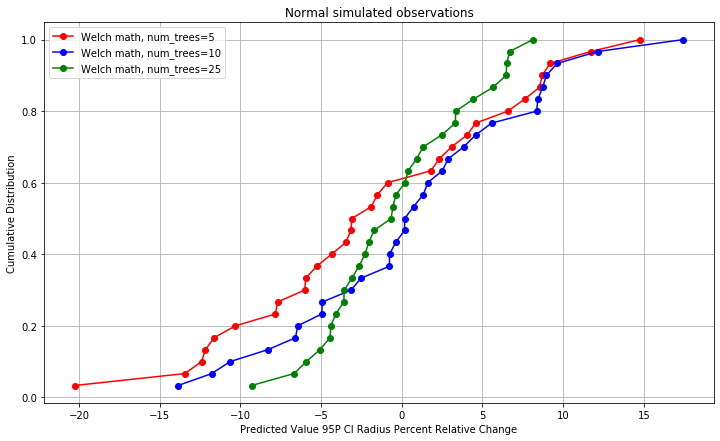

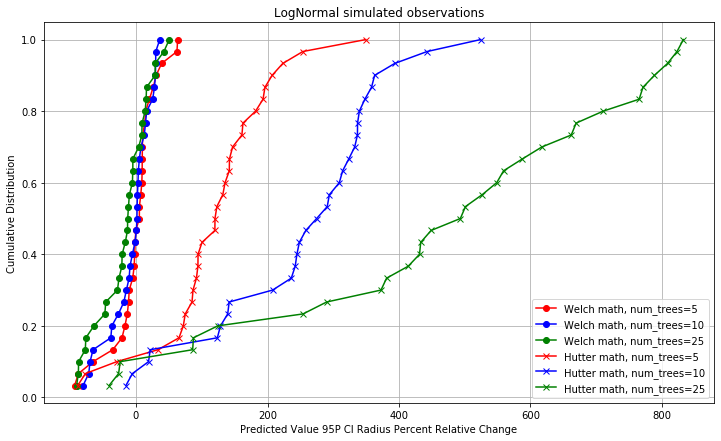

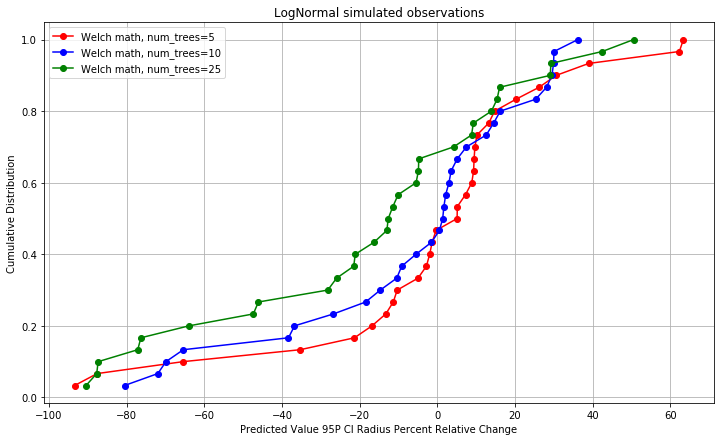

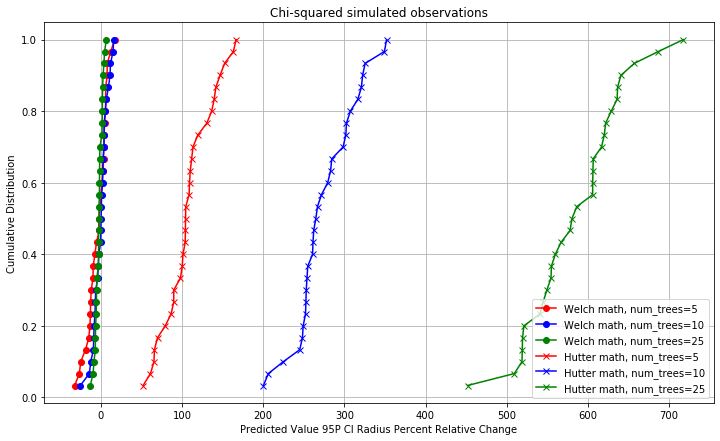

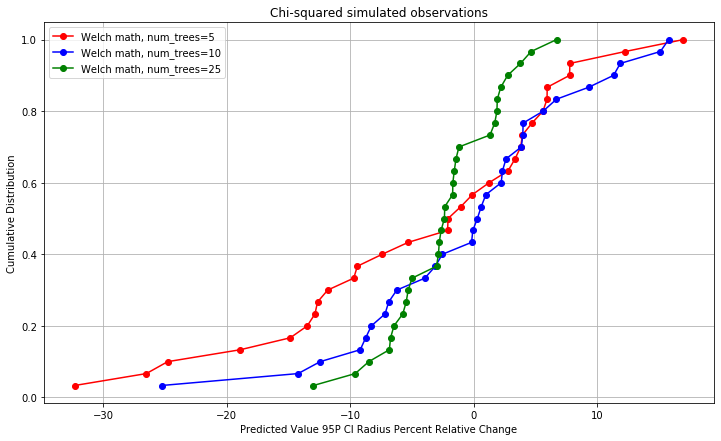

In [6]:
# 95% confidence interval radius value
xlabel = 'Predicted Value 95P CI Radius Percent Relative Change'
measurement_cdfs = all_cdfs_df.loc[all_cdfs_df['measure_name'] == 'predicted_value_95P_CI_radius_relative_change', :]
normal_cdf_sample_var = measurement_cdfs.loc[measurement_cdfs['distribution'] == 'dist=normal', :]
plot_cdf_overlays(normal_cdf_sample_var, 'Normal simulated observations', xlabel)
plot_cdf_overlays(normal_cdf_sample_var, 'Normal simulated observations', xlabel, show_hutter_plots=False)

lognormal_cdf_sample_var = measurement_cdfs.loc[measurement_cdfs['distribution'] == 'dist=lognormal', :]
plot_cdf_overlays(lognormal_cdf_sample_var, 'LogNormal simulated observations', xlabel)
plot_cdf_overlays(lognormal_cdf_sample_var, 'LogNormal simulated observations', xlabel, show_hutter_plots=False)

chi_sq_cdf_sample_var = measurement_cdfs.loc[measurement_cdfs['distribution'] == 'dist=chisquared', :]
plot_cdf_overlays(chi_sq_cdf_sample_var, 'Chi-squared simulated observations', xlabel)
plot_cdf_overlays(chi_sq_cdf_sample_var, 'Chi-squared simulated observations', xlabel, show_hutter_plots=False)

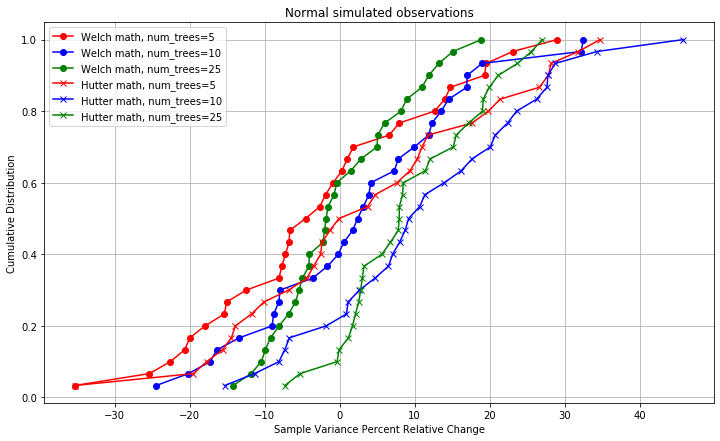

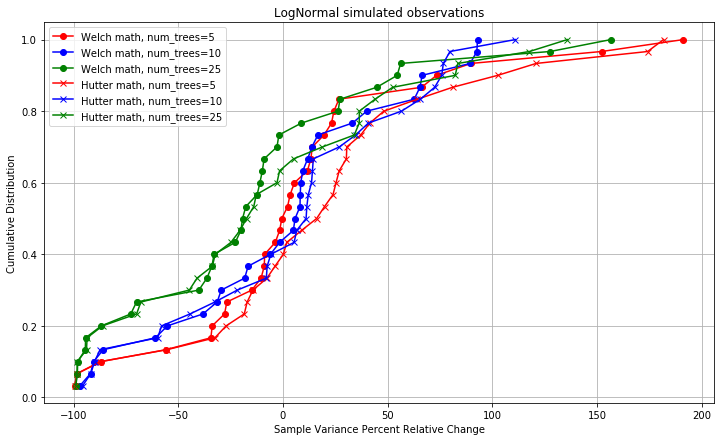

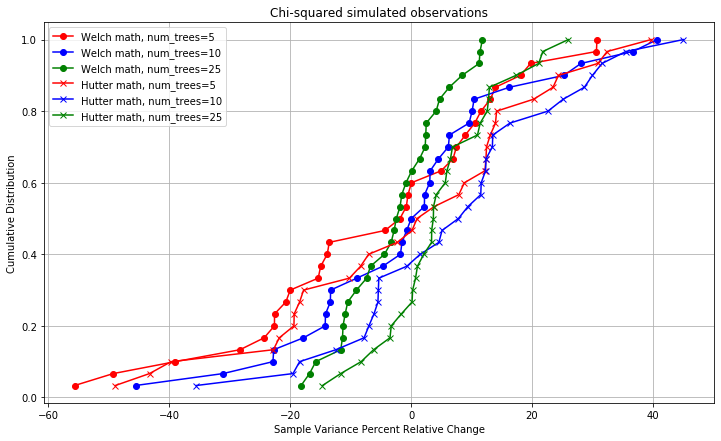

In [7]:
# sample variances
xlabel = 'Sample Variance Percent Relative Change'
measurement_cdfs = all_cdfs_df.loc[all_cdfs_df['measure_name'] == 'sample_var_relative_change', :]
normal_cdf_sample_var = measurement_cdfs.loc[measurement_cdfs['distribution'] == 'dist=normal', :]
plot_cdf_overlays(normal_cdf_sample_var, 'Normal simulated observations', xlabel)

lognormal_cdf_sample_var = measurement_cdfs.loc[measurement_cdfs['distribution'] == 'dist=lognormal', :]
plot_cdf_overlays(lognormal_cdf_sample_var, 'LogNormal simulated observations', xlabel)

chi_sq_cdf_sample_var = measurement_cdfs.loc[measurement_cdfs['distribution'] == 'dist=chisquared', :]
plot_cdf_overlays(chi_sq_cdf_sample_var, 'Chi-squared simulated observations', xlabel)


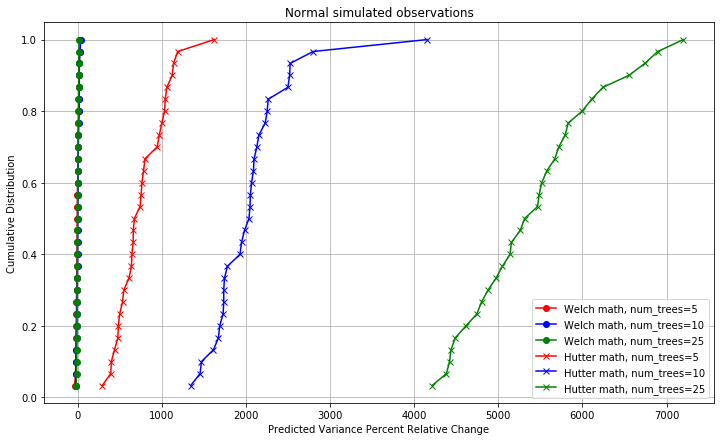

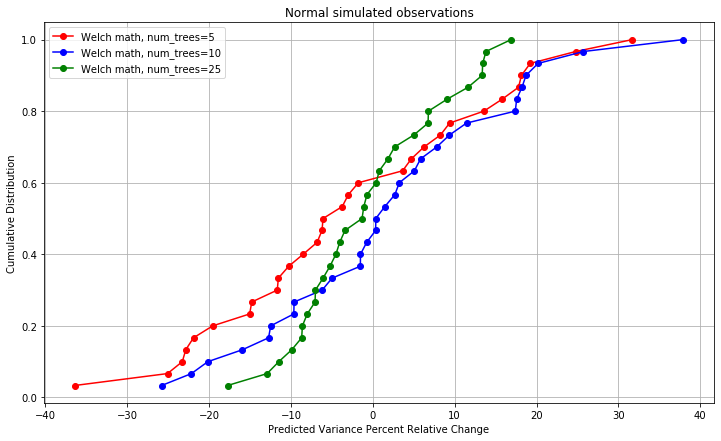

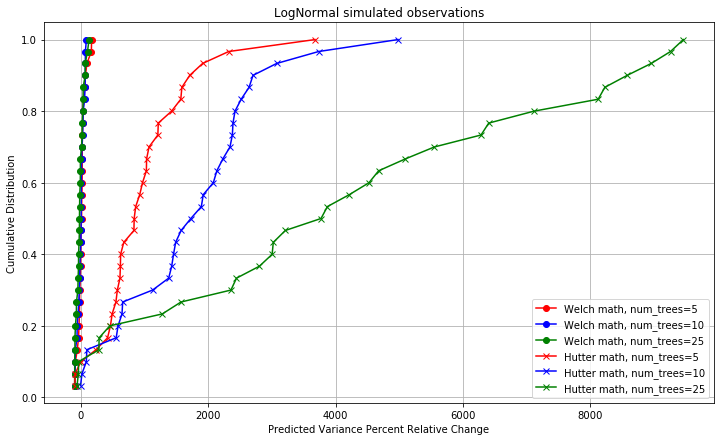

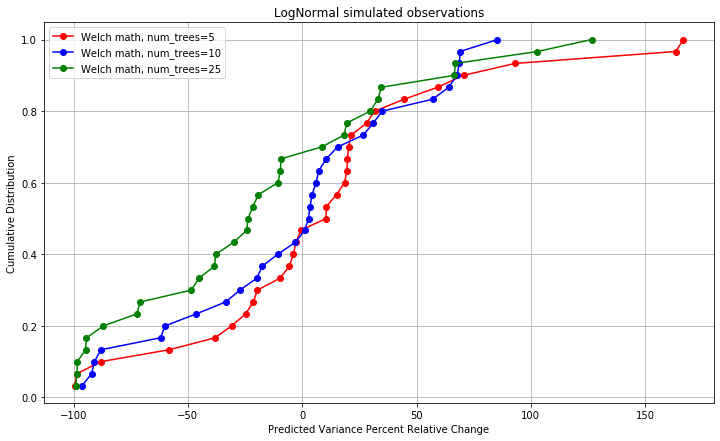

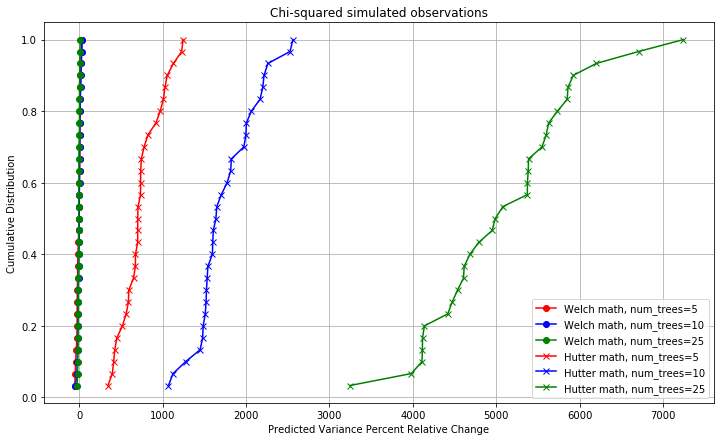

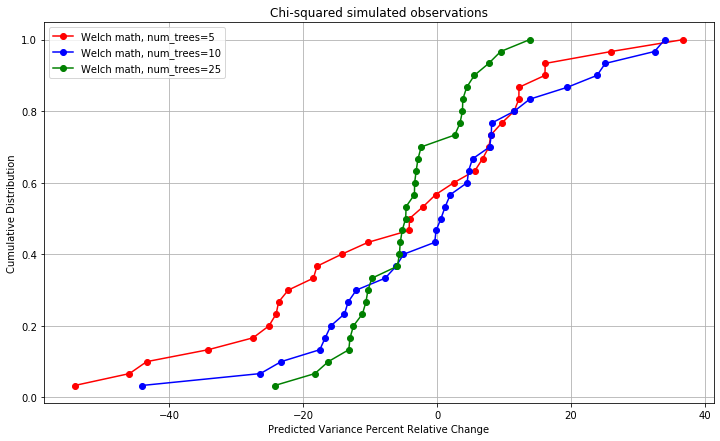

In [8]:
# prediction variances
xlabel = 'Predicted Variance Percent Relative Change'
measurement_cdfs = all_cdfs_df.loc[all_cdfs_df['measure_name'] == 'predicted_var_relative_change', :]
normal_cdf_sample_var = measurement_cdfs.loc[measurement_cdfs['distribution'] == 'dist=normal', :]
plot_cdf_overlays(normal_cdf_sample_var, 'Normal simulated observations', xlabel)
plot_cdf_overlays(normal_cdf_sample_var, 'Normal simulated observations', xlabel, show_hutter_plots=False)

lognormal_cdf_sample_var = measurement_cdfs.loc[measurement_cdfs['distribution'] == 'dist=lognormal', :]
plot_cdf_overlays(lognormal_cdf_sample_var, 'LogNormal simulated observations', xlabel)
plot_cdf_overlays(lognormal_cdf_sample_var, 'LogNormal simulated observations', xlabel, show_hutter_plots=False)

chi_sq_cdf_sample_var = measurement_cdfs.loc[measurement_cdfs['distribution'] == 'dist=chisquared', :]
plot_cdf_overlays(chi_sq_cdf_sample_var, 'Chi-squared simulated observations', xlabel)
plot_cdf_overlays(chi_sq_cdf_sample_var, 'Chi-squared simulated observations', xlabel, show_hutter_plots=False)